# <font color = 'red'> Analisando Sentimentos das reclamações</font>

In [1]:
!pip install -q textblob

In [11]:
!pip install -q --upgrade transformers


In [1]:
# Imports
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

from textblob import TextBlob

import warnings
warnings.filterwarnings('ignore')

In [2]:
dados_sentimento = pd.read_csv('/Projetos Pessoais/DataScience/PLN_Text_Analysis/data/dados_financeiros_sentimentos.csv',
                       sep =',')

In [15]:
comentarios_por_empresa = dados_sentimento.Empresa.value_counts().reset_index(name = "Total_Relatos")
comentarios_por_empresa.head()

,Empresa,Total_Relatos
0,Nubank,641
1,Banco do Brasil,541
2,Caixa Econômica Federal,465
3,Banco Santander,310
4,Mercado Pago,297


In [3]:
# Verificando notas das avaliações por cada empresa
df_avaliacao = dados_sentimento.groupby("Empresa")['Avaliacao'].value_counts().reset_index()

In [4]:
df_avaliacao

,Empresa,Avaliacao,count
0,Banco Bradesco,1,147
1,Banco Bradesco,5,58
2,Banco Bradesco,3,29
3,Banco Bradesco,4,23
4,Banco Bradesco,2,21
5,Banco Inter (Banco Intermedium),1,156
6,Banco Inter (Banco Intermedium),5,31
7,Banco Inter (Banco Intermedium),3,12
8,Banco Inter (Banco Intermedium),4,9
9,Banco Inter (Banco Intermedium),2,9


Verificando agora o gráfico de contagem para as empresas

In [9]:
df_avaliacao.Empresa.unique()

array(['Banco Bradesco', 'Banco Inter (Banco Intermedium)',
       'Banco Itaú Unibanco', 'Banco Pan', 'Banco Santander',
       'Banco do Brasil', 'C6 Bank', 'Caixa Econômica Federal',
       'Mercado Pago', 'Nubank', 'PicPay'], dtype=object)

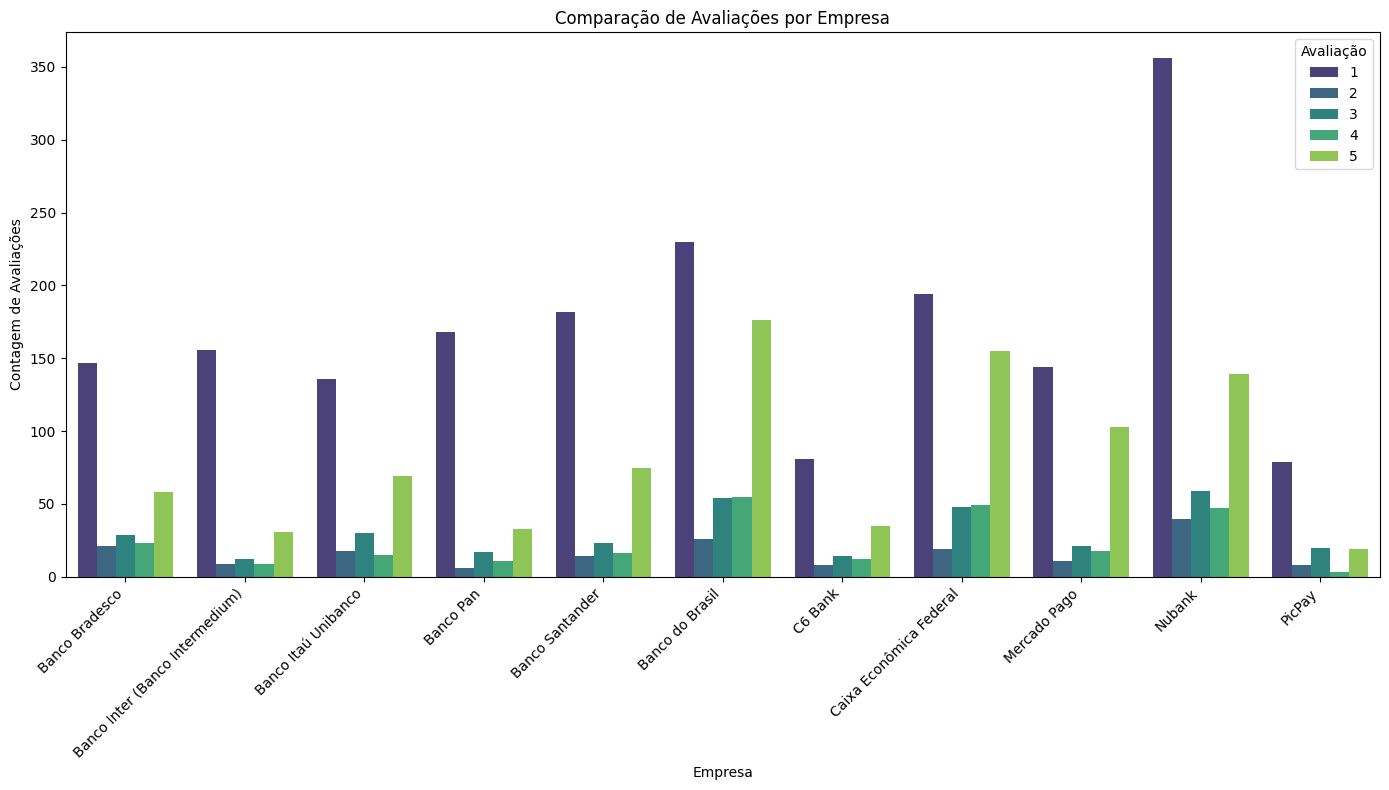

In [7]:
plt.figure(figsize=(14, 8))
sns.barplot(data=df_avaliacao, x='Empresa', y='count', hue='Avaliacao', palette='viridis')
plt.title('Comparação de Avaliações por Empresa')
plt.xlabel('Empresa')
plt.ylabel('Contagem de Avaliações')
plt.xticks(rotation=45, ha='right')  # Rotacionando os rótulos do eixo x para melhor visualização
plt.legend(title='Avaliação')
plt.tight_layout()
plt.show()

In [19]:
bancos = df_avaliacao.Empresa.unique()
for i in bancos:
 print(i)

Banco Bradesco
Banco Inter (Banco Intermedium)
Banco Itaú Unibanco
Banco Pan
Banco Santander
Banco do Brasil
C6 Bank
Caixa Econômica Federal
Mercado Pago
Nubank
PicPay


In [31]:
df_comparativo_1 = dados_sentimento.Empresa.value_counts().reset_index(name = "Total_Relatos")
df_comparativo_1

,Empresa,Total_Relatos
0,Nubank,641
1,Banco do Brasil,541
2,Caixa Econômica Federal,465
3,Banco Santander,310
4,Mercado Pago,297
5,Banco Bradesco,278
6,Banco Itaú Unibanco,268
7,Banco Pan,235
8,Banco Inter (Banco Intermedium),217
9,C6 Bank,150


Sumarizando e resumindo relatos grandes

In [8]:
dados_sentimento.sample(5)

,Empresa,Relato,Avaliacao
659,Nubank,ao pagar uma dívida com desconto o banco envio...,3
994,Nubank,ja foram pagas os debitos e ja estou utilizand...,5
2359,Banco Bradesco,verifiquei a realização de empréstimos pessoai...,3
3089,Banco do Brasil,cópia do contrato e da planilha de evolução do...,5
1511,Banco Bradesco,boa tarde gostaria de pedir a retirada das min...,1


In [33]:
dados_sentimento.shape

(3531, 3)

In [34]:
dados_sumarizacao = dados_sentimento.copy()

In [35]:
dados_sumarizacao["Len_Relato"] = dados_sumarizacao["Relato"].apply(lambda x: len(x))

In [37]:
dados_sumarizacao.sample(20)

,Empresa,Relato,Avaliacao,Len_Relato
2562,Mercado Pago,prezados venho por meio desta solicitar a regu...,4,1291
2591,Banco Itaú Unibanco,boa tarde liguei hoje dia por volta das para...,1,1838
1548,Nubank,solicito a memoria de calculo do emprestimo e ...,1,111
1841,PicPay,quero cancelar o parcelamento pois vou pagar j...,3,341
2057,Banco Pan,solicito copia do contrato do empréstimo consi...,1,51
1753,Nubank,estou co meu nome no scr quero que retiro pois...,1,263
617,Mercado Pago,contratei um empréstimo na minha conta mercado...,1,275
220,Banco do Brasil,peço a retirado dos valores que constam como p...,1,186
68,Banco do Brasil,a dívida já ultrapassou o prazo de anos e que...,3,90
485,Banco Santander,boa tarde gostaria de entender por qual motivo...,1,204


In [38]:
from transformers import pipeline

# 1. Criar pipeline de sumarização
sumarizador = pipeline("summarization", model="t5-small", tokenizer="t5-small")

# 2. Filtrar textos longos
limite_palavras = 512
dados_sentimento["Texto_Resumido"] = dados_sentimento["Relato"].apply(
    lambda texto: sumarizador(texto, max_length=limite_palavras, min_length=50, do_sample=False)[0]["summary_text"]
    if len(texto.split()) > limite_palavras else texto
)

# 3. Conferir resultado
print(dados_sentimento[["Relato", "Texto_Resumido"]])

Token indices sequence length is longer than the specified maximum sequence length for this model (1314 > 512). Running this sequence through the model will result in indexing errors


                                                 Relato  \
0     estão adicionando valores de juros abusivos e ...   
1     eu fiz um empréstimo e atrasei para pagar mand...   
2     a loja da shoppe descontou  no meu pix não com...   
3     .entendo que pelo pagamento ter sido recente p...   
4     foi solicitado a nubank que retirassem mas os ...   
...                                                 ...   
3526  o banco reduziu meu limite sem nenhum comunica...   
3527  efetuei o pagamento do acordo referente a fatu...   
3528  paguei o acordo do cartão ainda consta no rela...   
3529  o banco bloqueou o cartão de crédito alegando ...   
3530  contratei a banco c bank pj após eu abrir meu ...   

                                         Texto_Resumido  
0     estão adicionando valores de juros abusivos e ...  
1     eu fiz um empréstimo e atrasei para pagar mand...  
2     a loja da shoppe descontou  no meu pix não com...  
3     .entendo que pelo pagamento ter sido recente p...  
4

In [40]:
dados_sentimento.sample(20)

,Empresa,Relato,Avaliacao,Texto_Resumido
3045,Banco Bradesco,prezados segue pedido para fazer cumprir resol...,4,prezados segue pedido para fazer cumprir resol...
3212,Nubank,preciso que o banco forneça o descritivo de ev...,2,preciso que o banco forneça o descritivo de ev...
268,Mercado Pago,eu contratei o serviço do mercado pago pra ter...,1,eu contratei o serviço do mercado pago pra ter...
784,Banco Santander,no dia tive o meu limite ultrapassado para o ...,1,no dia tive o meu limite ultrapassado para o ...
734,Banco Inter (Banco Intermedium),olá eu cancelei minha conta dia de agosto de ...,5,olá eu cancelei minha conta dia de agosto de ...
1389,Banco Inter (Banco Intermedium),não sou nem nunca fui cliente do banco inter p...,1,não sou nem nunca fui cliente do banco inter p...
971,Caixa Econômica Federal,eu ademar pereira lameu informo que o cartão d...,5,eu ademar pereira lameu informo que o cartão d...
1589,Banco Itaú Unibanco,em de maio de solicitei a portabilidade de s...,1,em de maio de solicitei a portabilidade de s...
315,Caixa Econômica Federal,no dia recebi por email uma carta do serasa q...,5,no dia recebi por email uma carta do serasa q...
80,Banco do Brasil,notificação para cancelamento de débito bem co...,5,notificação para cancelamento de débito bem co...


In [16]:
from transformers import AutoTokenizer, BertForSequenceClassification
import numpy as np
  
pred_mapper = {
    0: "POSITIVE",
    1: "NEGATIVE",
    2: "NEUTRAL"
  }

tokenizer = AutoTokenizer.from_pretrained("lucas-leme/FinBERT-PT-BR")
finbertptbr = BertForSequenceClassification.from_pretrained("lucas-leme/FinBERT-PT-BR")

tokens = tokenizer(["Hoje a bolsa caiu", "Hoje a bolsa subiu"], return_tensors="pt",
                    padding=True, truncation=True, max_length=512)
finbertptbr_outputs = finbertptbr(**tokens)

preds = [pred_mapper[np.argmax(pred)] for pred in finbertptbr_outputs.logits.cpu().detach().numpy()]

tokenizer_config.json:   0%|          | 0.00/559 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/438k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [48]:
from transformers import (
    AutoTokenizer, 
    BertForSequenceClassification,
    pipeline,
)

finbert_pt_br_tokenizer = AutoTokenizer.from_pretrained("lucas-leme/FinBERT-PT-BR")
finbert_pt_br_model = BertForSequenceClassification.from_pretrained("lucas-leme/FinBERT-PT-BR")

finbert_pt_br_pipeline = pipeline(task='text-classification', 
                                  model=finbert_pt_br_model, 
                                  tokenizer=finbert_pt_br_tokenizer,
                                  truncation=True)
finbert_pt_br_pipeline(['Hoje a bolsa caiu', 'Hoje a bolsa subiu'])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'label': 'NEGATIVE', 'score': 0.7304732799530029},
 {'label': 'POSITIVE', 'score': 0.5405582785606384}]

In [49]:
analise = finbert_pt_br_pipeline('Hoje a bolsa caiu')

In [50]:
analise[0]

{'label': 'NEGATIVE', 'score': 0.7304732799530029}

In [51]:
analise[0]["label"]

'NEGATIVE'

In [52]:
analise[0]["score"]

0.7304732799530029

In [ ]:
dados_sentimento[dados_sentimento["Relato"] > len(dados_sentimento["Relato"])]

In [72]:
dados_sentimento["tamano_do_resumido"] = dados_sentimento["Relato_resumido"].apply(lambda x: len(x))

In [74]:
dados_sentimento[dados_sentimento["tamano_do_resumido"] > 510]

,Empresa,Relato,Avaliacao,Relato_resumido,tamano,tamano_do_resumido
3,C6 Bank,sou cliente do c6 bank há tempos sempre manten...,1,sou cliente do c6 bank há tempos sempre manten...,1386,1386
8,Nubank,reclamação nubank gostaria de registrar minha ...,1,reclamação nubank gostaria de registrar minha ...,1534,1534
11,Banco do Brasil,boa tarde após minha reclamação aqui referente...,1,boa tarde após minha reclamação aqui referente...,517,517
21,Banco Inter (Banco Intermedium),dado o encerramento da minha conta há cashback...,1,dado o encerramento da minha conta há cashback...,1475,1475
23,C6 Bank,no dia 09102024 realizei a contratação do cdb ...,5,no dia 09102024 realizei a contratação do cdb ...,1010,1010
...,...,...,...,...,...,...
1909,Banco do Brasil,em 18102024 verifiquei o meu contrato de empre...,5,em 18102024 verifiquei o meu contrato de empre...,529,529
1910,Caixa Econômica Federal,meu nome é fábio alves pitombeira portador do ...,1,meu nome é fábio alves pitombeira portador do ...,1321,1321
1911,Caixa Econômica Federal,um homem identificado cm cary robert entrou em...,1,um homem identificado cm cary robert entrou em...,752,752
1912,C6 Bank,tentei o parcelamento da fatura pelo app no di...,5,tentei o parcelamento da fatura pelo app no di...,1235,1235


In [87]:
tesete1 = dados_sentimento[dados_sentimento["tamano"] < 510]

In [88]:
tesete1["Sentimento"] = dados_sentimento["Relato_resumido"].apply(lambda x: finbert_pt_br_pipeline(x)[0]['label'])

In [90]:
tesete1.sample(5)

,Empresa,Relato,Avaliacao,Relato_resumido,tamano,tamano_do_resumido,Sentimento
1508,Banco Inter (Banco Intermedium),solicitei a portabilidade do meu empréstimo co...,4,solicitei a portabilidade do meu empréstimo co...,145,145,NEUTRAL
490,Banco Santander,em menos de 40 dias empresa do grupo santander...,1,em menos de 40 dias empresa do grupo santander...,173,173,NEGATIVE
1467,Banco Itaú Unibanco,constam no site registrato do banco central dí...,1,constam no site registrato do banco central dí...,148,148,NEGATIVE
1185,Banco do Brasil,em 24102024 verifiquei a o extrato da conta na...,5,em 24102024 verifiquei a o extrato da conta na...,211,211,NEGATIVE
1780,Banco Santander,primeiramente gostaria de deixar registrado mi...,1,primeiramente gostaria de deixar registrado mi...,368,368,NEGATIVE


In [93]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", tokenizer="facebook/bart-large-cnn")

# Aplicar a análise de sentimentos nos textos maiores que 510
dados_sentimento["Sentimento_maior_510"] = dados_sentimento["Relato"].apply(
    lambda x: finbert_pt_br_pipeline(summarizer(x, max_length=512, min_length=50, do_sample=False)[0]['summary_text'])[0]['label'] 
    if len(x.split()) > 510 else finbert_pt_br_pipeline(x)[0]['label']
)

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

RuntimeError: The size of tensor a (620) must match the size of tensor b (512) at non-singleton dimension 1

#### <font color = "red"> Verificando Sentimento dos comentários

In [14]:
model_name = "lipaoMai/BERT-sentiment-analysis-portuguese"

# Carregar tokenizer e modelo
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Criar pipeline de análise de sentimentos
sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Testar com uma frase
resultado = sentiment_analysis("Eu gosto muito deste banco, é excelente!")
print(resultado)

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

[{'label': 'LABEL_1', 'score': 0.9975929856300354}]


In [15]:
resultado2 = sentiment_analysis("Odeio você")
print(resultado2)

[{'label': 'LABEL_0', 'score': 0.6380139589309692}]


In [53]:
dados_sentimento["Sentimento"] = dados_sentimento['Relato'].apply(lambda x: finbert_pt_br_pipeline(x)[0]["label"])

RuntimeError: The size of tensor a (620) must match the size of tensor b (512) at non-singleton dimension 1

In [4]:
dados_sentimento.sample(20)

,Empresa,Relato,Avaliacao
123,Nubank,verifiquei em data 30102024 verifiquei a o ext...,1
1478,Nubank,prezados em junho minha conta bancária foi can...,1
1217,Banco do Brasil,eu paulo thiago lima costa barreto cpf xxx.xxx...,5
1283,Banco Santander,venho solicitar o cancelamento do seguro prest...,1
1885,Caixa Econômica Federal,venho solicitar todos os meus contratos bancar...,5
914,Banco Inter (Banco Intermedium),minha conta no banco inter está paga mas ainda...,4
1046,C6 Bank,solicito o encerramento da minha conta corrent...,5
1105,Banco Bradesco,procurei o banco e fiz parcelamento da divida ...,5
32,Banco Inter (Banco Intermedium),essa reclamação não tem nenhuma relação com a ...,1
1101,Banco Bradesco,no dia 24102024 recebi uma ligação que suposta...,1


In [ ]:
dados_sentimento.shape

(1920, 3)

In [35]:
### Função para obter subjetividade
def subjetividade(text):
 blob = TextBlob(text)
 return blob.sentiment.subjectivity

In [36]:
# Função para obter polaridade
def polaridade(text):
 blob = TextBlob(text)
 return blob.sentiment.polarity

In [37]:
# Adicionando no DF
dados_sentimento['Subjetividade'] = dados_sentimento['Relato'].apply(subjetividade)
dados_sentimento['Polaridade'] = dados_sentimento['Relato'].apply(polaridade)

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch import nn
import torch

# Carregar o modelo pré-treinado RoBERTa-BR
model_name = "neuralmind/bert-base-portuguese-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Função de predição de sentimento
def sentiment_analysis(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    sentiment = torch.argmax(logits, dim=1).item()
    return sentiment  # 0 = negativo, 1 = positivo

# Teste com exemplo de reclamação
text = "minha conta bancária foi cancelada sem aviso prévio"
sentiment = sentiment_analysis(text)

print("Sentimento:", "Positivo" if sentiment == 1 else "Negativo")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sentimento: Negativo


In [38]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch import nn
import torch

# Carregar o modelo pré-treinado RoBERTa-BR
model_name = "neuralmind/bert-base-portuguese-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Função de predição de sentimento com níveis de intensidade
def sentiment_analysis_with_intensity(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = nn.functional.softmax(logits, dim=1)

    # Extrair probabilidades de cada classe
    negative_score = probabilities[0][0].item()
    positive_score = probabilities[0][1].item()
    
    # Ajuste das intensidades com base nas probabilidades
    if positive_score >= 0.85:
        return "Muito Positivo"
    elif positive_score >= 0.65:
        return "Positivo"
    elif negative_score >= 0.85:
        return "Muito Negativo"
    elif negative_score >= 0.65:
        return "Negativo"
    else:
        return "Neutro"

# Teste com exemplo de reclamação
text = "minha conta bancária foi cancelada sem aviso prévio"
intensity = sentiment_analysis_with_intensity(text)
print("Intensidade do Sentimento:", intensity)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Intensidade do Sentimento: Neutro


In [39]:
text = "Irei recomendar seus serviços, muito bom"
intensity = sentiment_analysis_with_intensity(text)
print("Intensidade do Sentimento:", intensity)

Intensidade do Sentimento: Neutro


In [47]:
text = "odeio tudo isso"
text2 = "te amo"


print("Sentimento:", "Positivo" if sentiment_analysis(text) == 1 else "Negativo")
print("Sentimento:", "Positivo" if sentiment_analysis(text2) == 1 else "Negativo")



Sentimento: Negativo
Sentimento: Negativo


In [42]:
dados_sentimento.head(10)

,Empresa,Relato,Avaliacao
0,Caixa Econômica Federal,não consigo crédito pra fazer um empréstimo me...,3
1,Nubank,ja houve o pagamento da negociacao,2
2,Nubank,exclusao do nome retirar negativacao do nome s...,1
3,C6 Bank,sou cliente do c6 bank há tempos sempre manten...,1
4,Nubank,gostaria de reclamar sobre essa dívida quer es...,5
5,Banco Itaú Unibanco,o itaú financiamentos fez constar na scr uma l...,1
6,Nubank,eu fiz um acordo para pagamento da minha dívid...,3
7,Banco Itaú Unibanco,primeiramente quero agradecer o banco itau poi...,5
8,Nubank,reclamação nubank gostaria de registrar minha ...,1
9,Caixa Econômica Federal,desejo participar do mutirão de renegociação.,1


In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Carregar o modelo pré-treinado para análise de sentimento
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
model = AutoModelForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased")

# Função para prever a polaridade e intensidade com RoBERTa-BR
def get_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    scores = outputs.logits.softmax(dim=1).detach().numpy()
    
    # Exemplos de interpretação (ajustar conforme os rótulos do modelo que está usando)
    sentiment = "positivo" if scores[0][1] > scores[0][0] else "negativo"
    intensity = scores[0][1]  # Considerando que pontuações mais altas indicam mais intensidade
    
    return sentiment, intensity

# Aplicar o modelo para obter polaridade e intensidade
dados_sentimento['Polaridade'], dados_sentimento['Intensidade'] = zip(*dados_sentimento['Relato'].apply(get_sentiment))

# Exibir o resultado
print(dados_sentimento)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

In [46]:
dados_sentimento.sample(20)

,Empresa,Relato,Avaliacao,Polaridade,Intensidade
1307,Banco Bradesco,prezadoa solicito que entrem em contato o quan...,5,negativo,0.409989
1311,Banco Itaú Unibanco,preciso que excluem está dívida caduca em meu ...,2,negativo,0.463328
48,Nubank,solicitei ao banco o descritivo de evolução da...,1,negativo,0.463280
1895,Caixa Econômica Federal,acredito que os juros mensais estão muito elev...,1,negativo,0.409643
1292,Caixa Econômica Federal,fiz no dia 17102024 uma locação de um carro na...,5,negativo,0.412969
1183,Banco Santander,eu estava com dividas nos bancos santander i...,5,negativo,0.404824
990,Banco Inter (Banco Intermedium),tive meu celular furtado no dia 21024 na mesma...,5,negativo,0.409019
844,Nubank,venho por meio desta solicitar uma renegociaçã...,1,negativo,0.412940
1201,Banco do Brasil,recebi um consócio cedente de adesão número 4....,5,negativo,0.428601
494,Caixa Econômica Federal,boa tarde vi que tenho pendências na caixa eco...,1,negativo,0.426547


In [47]:
dados_sentimento.Polaridade.value_counts()

Polaridade
negativo    1892
positivo      28
Name: count, dtype: int64

In [48]:
dados_sentimento[dados_sentimento['Polaridade'] == 'positivo']

,Empresa,Relato,Avaliacao,Polaridade,Intensidade
16,Nubank,em 04112024 verifiquei a o extrato cartão de ...,1,positivo,0.510398
59,Nubank,em 03112024 verifiquei ao registrato na qual c...,3,positivo,0.513293
192,Nubank,em 31102024 verifiquei a o extrato da conta co...,1,positivo,0.503650
248,Nubank,verifiquei junto ao serasa uma dívida em abert...,1,positivo,0.519736
263,Banco do Brasil,em 31102024 verifiquei a o extrato cartão de c...,1,positivo,0.504479
403,Banco do Brasil,por várias vezes fui a agência em busca de inf...,1,positivo,0.500896
438,Banco do Brasil,que de baixa a registros anteriores a cinco an...,1,positivo,0.503873
481,Nubank,em 14 de abril de 2024 verifiquei a o extrato ...,1,positivo,0.505893
543,Nubank,em 29102024 verifiquei a o extrato extrato ca...,1,positivo,0.505728
555,Nubank,em 2910 verifiquei a o extrato do cartão de cr...,1,positivo,0.503945
